In [3]:
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [42]:
# stock tickers and the time period (last 5 years)
tickers = ['NVDA']
start_date = '2020-03-10'
end_date = '2025-03-10'  

In [43]:
# download and format data for a single stock
def download_and_format_stock_data(ticker, start_date, end_date, retries=3):
    for i in range(retries):
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            if not stock_data.empty:
                stock_data.reset_index(inplace=True)
                stock_data['Name'] = ticker
                stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name']]
                stock_data['Date'] = stock_data['Date'].dt.date 
                stock_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'name']
                return stock_data
        except Exception as e:
            print(f"Attempt {i+1} failed for {ticker}: {e}")
    return pd.DataFrame()

In [44]:
# download and format data for all tickers
stocks_data = pd.concat([download_and_format_stock_data(ticker, start_date, end_date) for ticker in tickers])

[*********************100%***********************]  1 of 1 completed


In [45]:
print(stocks_data.head())

# save the data to a CSV file
file_path = 'stock_data.csv'
stocks_data.to_csv(file_path, index=False)

         date      open      high       low     close     volume  name
0  2020-03-10  6.390545  6.503639  6.127739  6.503639  580648000  NVDA
1  2020-03-11  6.363643  6.392041  6.042546  6.139697  499964000  NVDA
2  2020-03-12  5.616326  5.881873  5.375691  5.388395  816540000  NVDA
3  2020-03-13  5.741875  6.003934  5.470600  5.999450  634836000  NVDA
4  2020-03-16  5.291243  5.632269  4.832641  4.892426  726972000  NVDA


In [18]:
stocks_data.shape

(1256, 7)

In [19]:
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1256 non-null   object 
 1   open    1256 non-null   float64
 2   high    1256 non-null   float64
 3   low     1256 non-null   float64
 4   close   1256 non-null   float64
 5   volume  1256 non-null   int64  
 6   name    1256 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 68.8+ KB


In [20]:
stocks_data.describe()

,open,high,low,close,volume
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,42.884820,43.676993,41.981445,42.858681,4.400949e+08
std,41.462024,42.178243,40.524940,41.359116,1.849450e+08
min,4.984595,5.229715,4.500833,4.892426,9.788400e+07
25%,14.208222,14.439162,13.948668,14.249612,3.025202e+08
50%,22.480651,22.913987,22.063598,22.516796,4.152430e+08
75%,48.449198,49.143578,47.839270,48.496737,5.424215e+08
max,153.029999,153.130005,147.820007,149.429993,1.543911e+09


In [21]:
# convert the date column to datetime and set it as the index
stocks_data['date'] = pd.to_datetime(stocks_data['date'])
# stocks_data.set_index('date', inplace=True)

In [22]:
# visualize close price history for stocks
def close_price_plot(symbols):
    for symbol in symbols:
        plt.figure(figsize=(10,5))
        sns.lineplot(data=stocks_data[stocks_data['name'] == symbol], x='date', y='close')
        plt.title(f'{symbol} Close Price')
        plt.xlabel('Year')
        plt.ylabel('Price')
        plt.show()

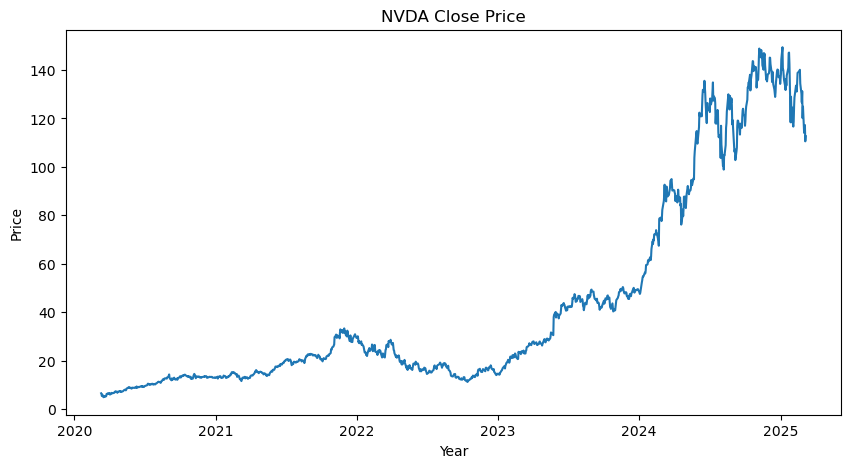

In [23]:
close_price_plot(['NVDA'])

In [24]:
# visulizing the trading volume
def trading_volume_plot(symbols):
    for symbol in symbols:
        plt.figure(figsize=(10,5))
        sns.lineplot(data=stocks_data[stocks_data['name'] == symbol], x='date', y='volume')
        plt.title(f'Trading Volume for {symbol}')
        plt.xlabel('Year')
        plt.ylabel('Volume')
        plt.show()

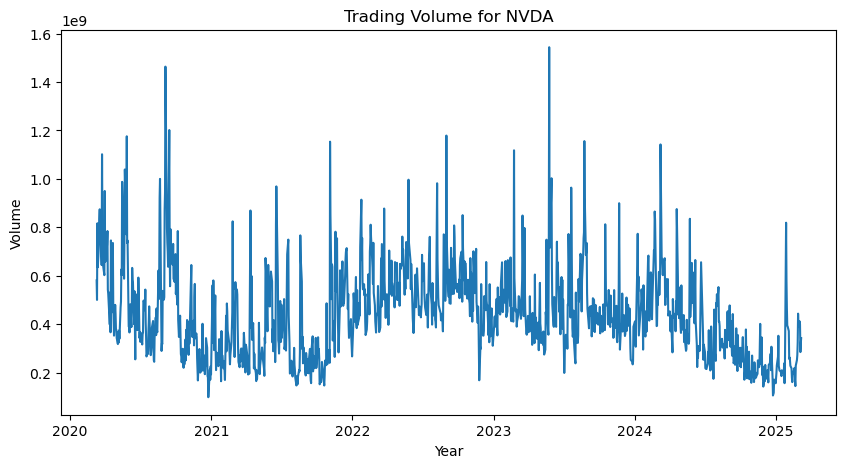

In [25]:
trading_volume_plot(['NVDA'])

In [26]:
# daily returns
stocks_data['daily returns'] = stocks_data['close'].pct_change()

In [27]:
# visulizing the daily returns
def daily_returns_plot(symbols):
    for symbol in symbols:
        plt.figure(figsize=(10,5))
        sns.lineplot(data=stocks_data[stocks_data['name'] == symbol], x='date', y='daily returns')
        plt.title(f'Daily Returns for {symbol}')
        plt.xlabel('Year')
        plt.ylabel('Daily Returns')
        plt.show()

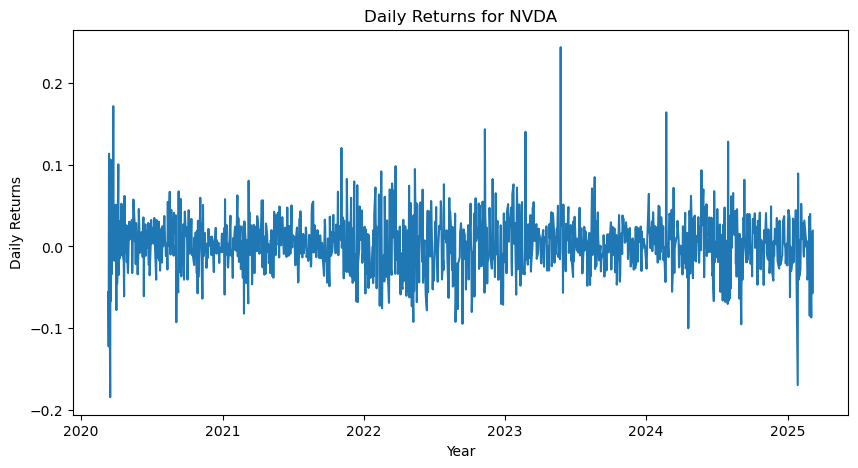

In [28]:
daily_returns_plot(['NVDA'])

In [29]:
# simple moving average over 30 days
window_size = 30  
stocks_data['moving average'] = stocks_data['close'].rolling(window=window_size).mean()

In [30]:
# visulizing the simple moving average
def moving_average_plot(symbols):
    for symbol in symbols:
        plt.figure(figsize = (10, 5))
        sns.lineplot(data=stocks_data[stocks_data['name'] == symbol], x='date', y='close', label='Close')
        sns.lineplot(data=stocks_data[stocks_data['name'] == symbol], x='date', y='moving average', color='red', label='30-day SMA')
        plt.title(f"{symbol} Stock Price with SMA")
        plt.xlabel("Year")
        plt.ylabel("Price")
        plt.show()

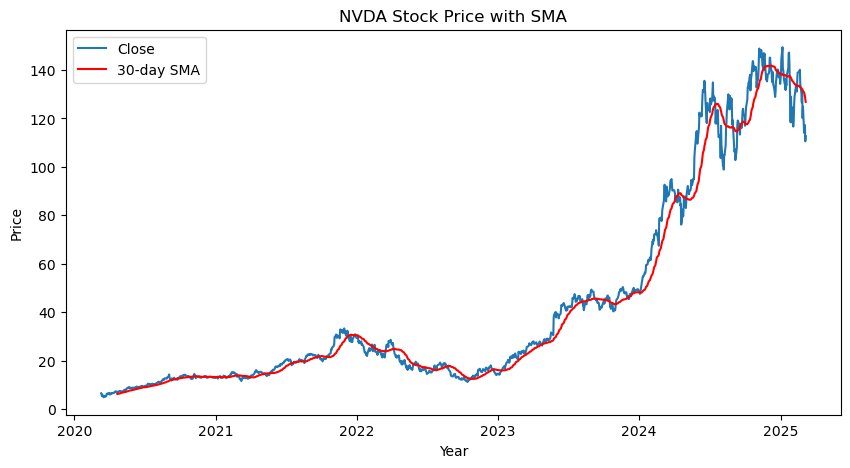

In [31]:
moving_average_plot(['NVDA'])

### hmm

In [32]:
# splitting the stocks into separate dataframes
nvda_df = stocks_data[stocks_data['name'] == 'NVDA']['close']

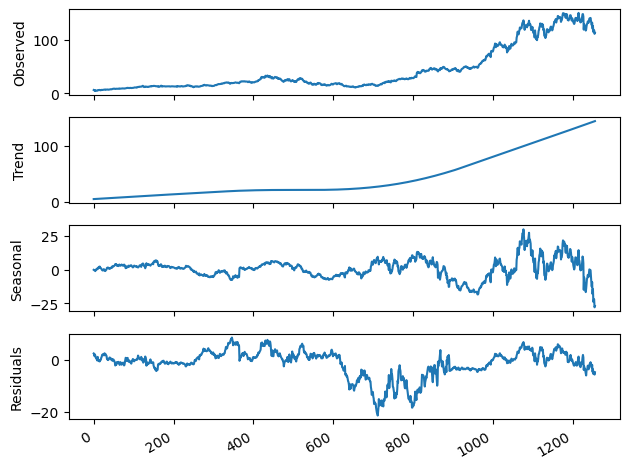

In [33]:
advanced_decomposition = STL(nvda_df, period=365).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [34]:
# checking for stationarity
result = adfuller(nvda_df.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.10222082264235213
p-value: 0.9492168812055224


In [35]:
nvda_diff = np.log(nvda_df)

### ARIMA

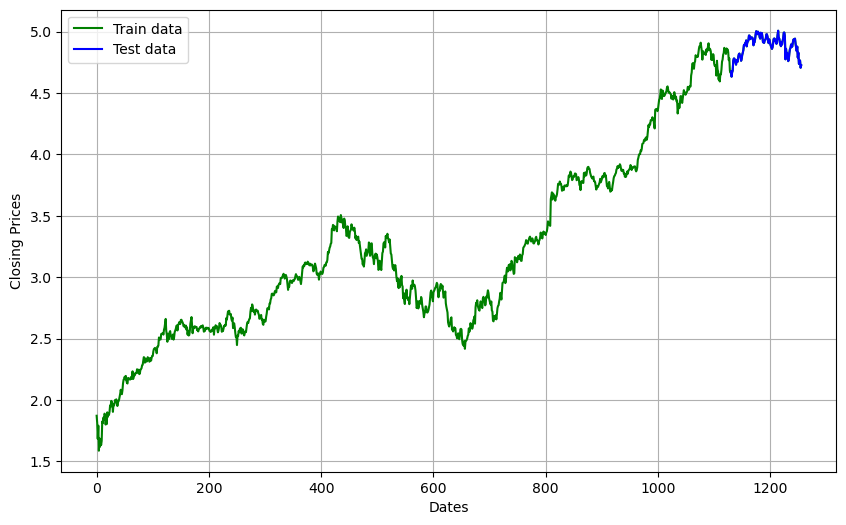

In [36]:
#split data into train and training set
train_data, test_data = nvda_diff[3:int(len(nvda_diff)*0.9)], nvda_diff[int(len(nvda_diff)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nvda_diff, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [37]:
# fitting the ARIMA model
ARIMA_model = auto_arima(train_data, 
                      start_p=0, 
                      start_q=0,
                      test='adf', # use adftest to find optimal 'd'
                      tr=13, max_p=5, max_q=5, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4426.056, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4431.229, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4430.972, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4421.671, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4429.617, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4430.132, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4427.550, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4425.681, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.098 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1127
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2218.614
Date:                Wed, 12 Mar 2025   AIC                          -4431.229
Time:                        12:31:45   BIC                          -4416.149
Sample:                             0   HQIC                         -4425.531
                               - 1127                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.001      2.742      0.006       0.001       0.005
ar.L1         -0.0810      0.027     -2.976      0.003      -0.134      -0.028
sigma2         0.0011   2.92e-05     38.991      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               586.79
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.15
Prob(H) (two-sided):                  0.56   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

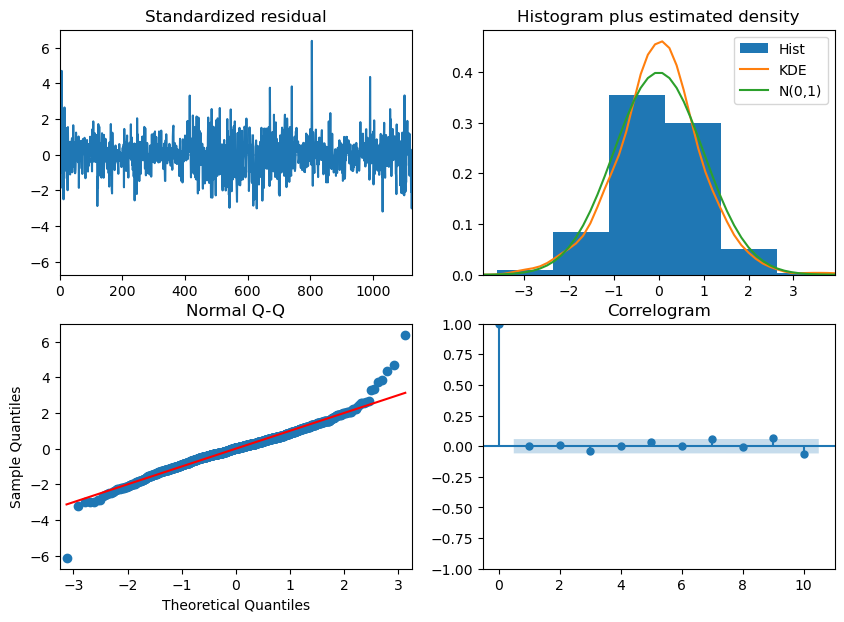

In [38]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [39]:
model = ARIMA(train_data, order=(1,1,0))
fitted_model = model.fit()  
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1127
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2214.840
Date:                Wed, 12 Mar 2025   AIC                          -4425.681
Time:                        12:31:57   BIC                          -4415.628
Sample:                             0   HQIC                         -4421.882
                               - 1127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0719      0.027     -2.648      0.008      -0.125      -0.019
sigma2         0.0011   2.93e-05     39.100      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.03   Jarque-

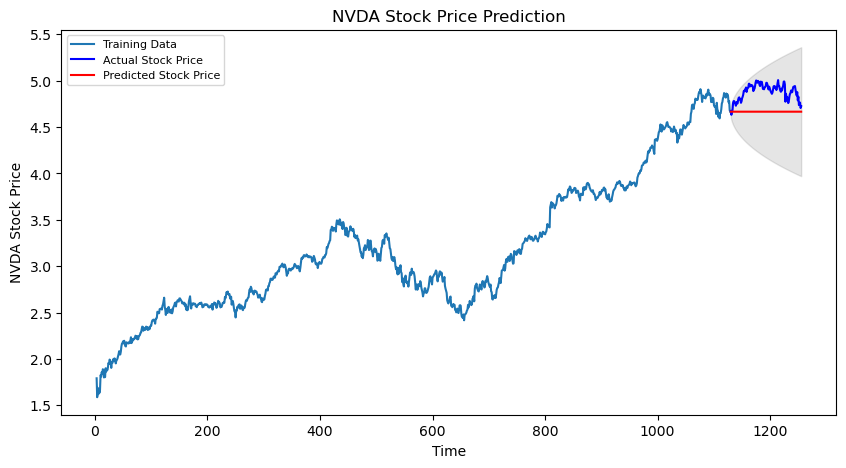

In [40]:
fc1 = fitted_model.get_forecast(len(test_data)).summary_frame()

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc1['mean'], color = 'red',label='Predicted Stock Price')
plt.fill_between(fc1.index, fc1['mean_ci_lower'], fc1['mean_ci_upper'], color='k', alpha=0.1)
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
mse = mean_squared_error(test_data, fc1['mean'])
print(f'MSE: {mse}')
mae = mean_absolute_error(test_data, fc1['mean'])
print(f'MAE: {mae}')
rmse = root_mean_squared_error(test_data, fc1['mean'])
print(f'RMSE: {rmse}')
mape = np.mean(np.abs(fc1['mean'] - test_data)/np.abs(test_data))
print(f'MAPE: {mape}')

MSE: 0.05340410247546681
MAE: 0.2157234048432335
RMSE: 0.2310932765691525
MAPE: 0.04390844814788684
